
# Defining a LP filter for the AMP SQUID feedback

## Laurent @IRAP

----

The firmware computes a feedback signal which, in nominal mode, is
applied to the MUX SQUID.
In some specific diagnostic modes this feedback is applied to the 
AMP SQUID. 
When applied on the AMP SQUID the sampling rate of the feedback signal
is much lower (the signal is provided with a low speed DAC). Thus a
low pass filter shall be applied on the signal in order to reduce the 
aliased noise.

This Notebook computes a low pass filter for the AMP SQUID feedback.

----

* Created 03/05/2023

----


In [2]:
###################################################
# imports
###################################################

import numpy as np
import matplotlib.pyplot as plt

 The number of decades in the comb is: 6.49
 The number of lines in the comb is: 65
 The frequency step is: x 1.26
   The frequencies are:
[1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03 1.25892541e+03
 1.58489319e+03 1.99526231e+03 2.51188643e+03 3.16227766e+03
 3.98107171e+03 5.01187234e+03 6.30957344e+03 7.94328235e+03
 1.00000000e+04 1.25892541e+04 1.58489319e+04 1.99526231e+04
 2.51188643e+04 3.16227766e+04 3.98107171e+04 5.01187234e+04
 6.30957344e+04 7.94328235e+04 1.00000000e+05 1.25892541e+05
 1.58489319e+05 1.99526231e+05 2.51188643e+05 3.16227766e+05
 3.9810

array([ -3.84590571,  -3.84532864, -10.3453371 , ...,   7.9145321 ,
         6.63950562,   7.01467141])

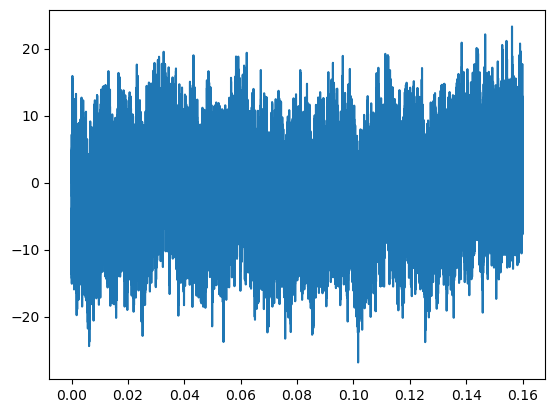

In [3]:
###################################################
# Definition of an input test pattern (comb)
###################################################

def mk_comb(npts, f_sampling=6.25e6, f_start=1, f_stop=3.125e6, n_lines_per_decade=10, verbose=0):
    r"""
    This function returns an array containing a comb signal.
    
    Parameters
    ----------
    npts : integer
        The length of the comb array
        
    f_sampling : float
        The sampling frequency of the comb signal in Hz (Default = 6.25e6)
        
    f_start : float
        The comb start frequency in Hz (Default = 1)
        
    f_stop : float
        The comb stop frequency in Hz (Default = 3.125e6)
        
    n_lines_per_decade : integer
        The  number of lines per decade (Default = 4)
        
    verbose : Boolean
        Defines the verbosity level: 0 -> none, 1 -> medium, 2 -> maximum (Default = 0)
         
    Output
    ------
    comb : numpy array
        The test signal

    """

    # Number of decades in the comb
    ndecades = np.log(f_stop / f_start) / np.log(10)
    
    # Number of lines in the comb
    nfreqs = np.round(ndecades * n_lines_per_decade).astype(int)
        
    # Frequency step
    fratio = 10**(1/n_lines_per_decade)
    
    # Frequencies
    freqs = f_start*fratio**np.arange(nfreqs)
    
    # Phases (random)
    phases = 2*np.pi*np.random.rand(nfreqs)
    
    # time vector
    t = np.arange(npts) / f_sampling
    
    # Making comb
    comb = np.zeros(npts)
    for i in range(nfreqs):
        comb += np.sin(2*np.pi*freqs[i]*t + phases[i])

    if verbose>0:
        print(" The number of decades in the comb is: {0:2.2f}".format(ndecades))
        print(" The number of lines in the comb is: {0:2d}".format(nfreqs))
        print(" The frequency step is: x {0:2.2f}".format(fratio))
        if verbose>1:
            print("   The frequencies are:")
            print(freqs)
        plt.plot(t, comb)
 
    return(comb)

mk_comb(1000000, verbose=2)

In [20]:
def mk_white_noise(npts, verbose=0):
    r"""
    This function returns an array containing a white noise.
    
    Parameters
    ----------
    npts : integer
        The length of the comb array
        
    verbose : Boolean
        Defines the verbosity level: 0 -> none, 1 -> medium, 2 -> maximum (Default = 0)
         
    Output
    ------
    noise : numpy array
        The test signal

    """
    
    return(np.random.rand(npts))

    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


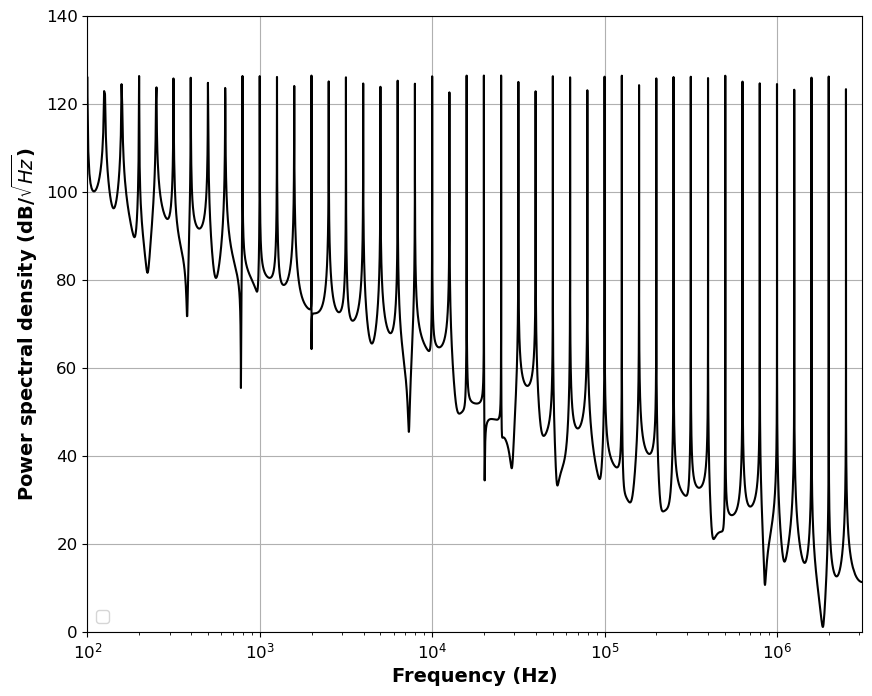

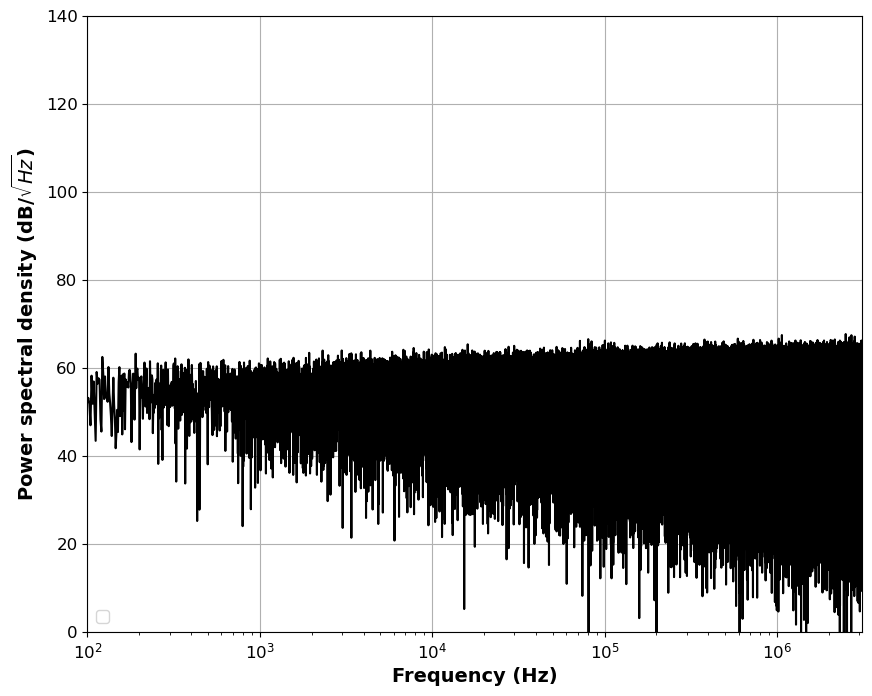

In [21]:
###################################################
# Definition of spectrum analyser function
###################################################
def mk_spectrum(signal, f_sampling=6.25e6, label=''):
    r"""
    This function plots the spectrum of the input signal

    Parameters
    ----------
    signal : numpy array
        Input signal (time domain)
        
    f_sampling : float
        The sampling frequency of the input signal in Hz (Default = 6.25e6)
        
    label : string
        The label of the signal on the plot
        
    """

    # Computing spectrum    
    npts = len(signal)
    signal_f = np.abs(np.fft.fft(signal)[0:int(npts/2)])
    signal_f_db = 20*np.log10(signal_f)

    # Frequency array
    f = np.arange(int(npts/2))*(f_sampling/npts) 
    
    # Ploting spectrum
    xlabel = r"Frequency (Hz)"
    ylabel = r"Power spectral density (dB/$\sqrt{Hz}$)"
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.semilogx(f, signal_f_db, 'k', label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_weight('bold')
        item.set_fontsize(14)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    ax.legend(loc='lower left', fontsize=12)
    ax.set_xlim([100, 3.125e6])
    ax.set_ylim([0, 140])
    ax.grid()    

    
mk_spectrum(mk_comb(int(2**22)))
mk_spectrum(mk_white_noise(int(2**22)))
    

array([0.03339509, 0.04337368, 0.05305452, 0.06198083, 0.06972076,
       0.07589292, 0.08018915, 0.08239305, 0.08239305, 0.08018915,
       0.07589292, 0.06972076, 0.06198083, 0.05305452, 0.04337368,
       0.03339509])

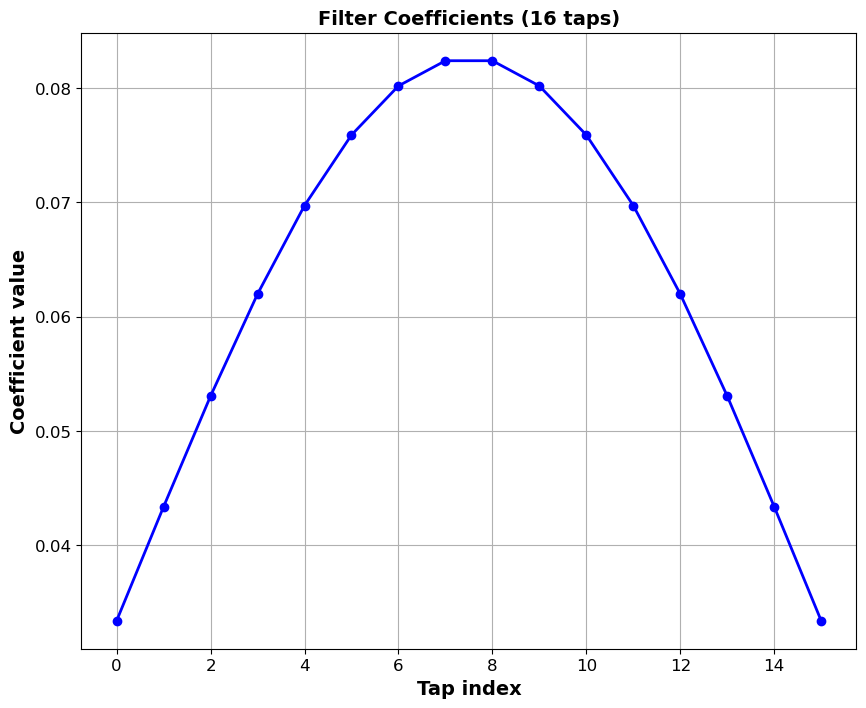

In [31]:
###################################################
# Definition of the FIR filter
###################################################
def mk_filter(f_sampling=6.25e6, cutoff=1e3, trans_width = 30e3, att_db=30.0):
    r"""
    This function computes a FIR filter

    Parameters
    ----------
    f_sampling : float
        The sampling frequency of the input signal in Hz (Default = 6.25e6)
        
    cutoff : float
        The cutoff frequency in Hz (Default = 1e3)
    
    trans_width : float
        The width of the transition in Hz (Default = 30e3)
    
    att_db : float
        The out-of-band attenuation in dB (Default = 40)
        
    """

#    from scipy.signal import kaiserord, firwin

    from scipy.signal import kaiserord, firwin

    # Nyquist rate
    nyq_rate = f_sampling / 2.0
    
    # Transition (Hz) 
    trans_width_norm = trans_width / nyq_rate 
    
    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(att_db, trans_width_norm)
    N=16

    # The cutoff frequency of the filter (Hz).
    cutoff_norm = cutoff / nyq_rate

    # Use firwin with a Kaiser window to create a lowpass FIR filter.
    taps = firwin(N, cutoff_norm, window=('kaiser', beta))

    # Ploting the coefficients
    tlabel = r"Filter Coefficients ({0:2d} taps)".format(N)
    xlabel = r"Tap index"
    ylabel = r"Coefficient value"
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(taps, 'bo-', linewidth=2)
    ax.set_title(tlabel)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_weight('bold')
        item.set_fontsize(14)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    ax.grid()  

    return(taps)  

mk_filter()


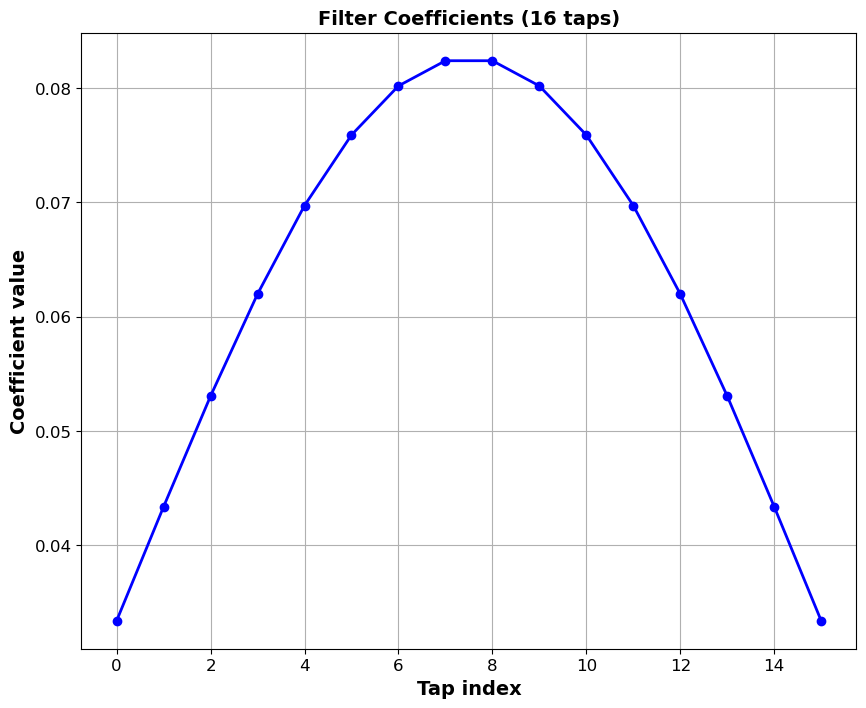

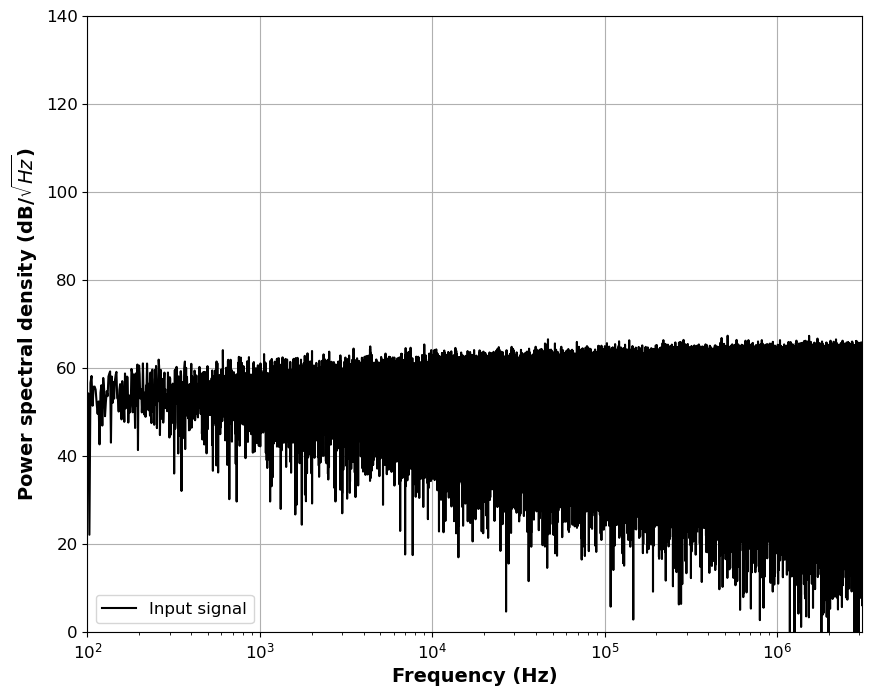

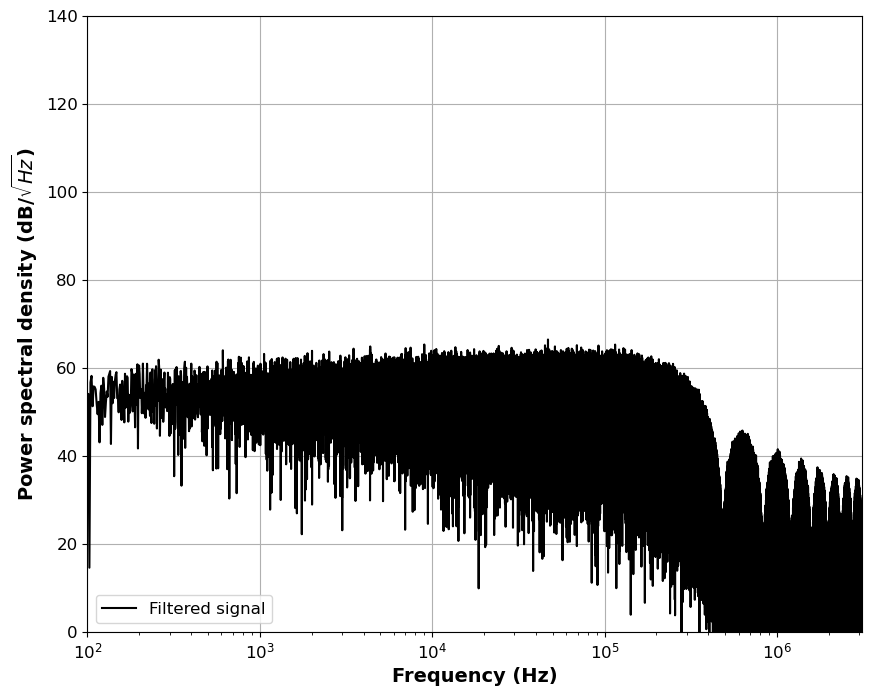

In [33]:
###################################################
# Filtering the signal
###################################################
def apply_filter():
    
    # Computing input signal
    #signal = mk_comb(int(2**22))
    signal = mk_white_noise(int(2**22))
    
    # Computing filter
    taps = mk_filter()
    
    # Applying filter
    signal_filt = np.convolve(signal, taps)

    
    # Plotting the spectra
    mk_spectrum(signal, label='Input signal')
    mk_spectrum(signal_filt, label='Filtered signal')
    
apply_filter()